In [1]:
import numpy as np
import os
from collections import Counter
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from skimage.feature import hog
from skimage import exposure
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

In [2]:
# Define KNN classifier class
class KNN(object):
    def __init__(self, k=3):
        self.k = k

    def train(self, X, y):
        # Encode labels
        self.labels_encoder = LabelEncoder()
        self.labels_encoder.fit(y)
        self.y_train_encoded = self.labels_encoder.transform(y)

        # Standardize features
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)

        # PCA for dimensionality reduction
        self.pca = PCA(n_components=50)
        self.X_train_pca = self.pca.fit_transform(X_scaled)

    def predict(self, X):
        # Standardize and PCA transform test data
        X_scaled = self.scaler.transform(X)
        X_test_pca = self.pca.transform(X_scaled)

        # Predict labels
        y_pred_encoded = self.predict_labels(X_test_pca)
        y_pred = self.labels_encoder.inverse_transform(y_pred_encoded)
        return y_pred

    def predict_labels(self, X_test):
        y_pred = []
        for x_test in X_test:
            # Calculate distances to all training samples
            distances = [np.linalg.norm(x_train - x_test) for x_train in self.X_train_pca]
            # Get indices of k nearest neighbors
            nearest_indices = np.argsort(distances)[:self.k]
            # Get labels of k nearest neighbors
            nearest_labels = self.y_train_encoded[nearest_indices]
            # Find the most common label
            most_common_label = Counter(nearest_labels).most_common(1)[0][0]
            y_pred.append(most_common_label)
        return np.array(y_pred)

In [3]:
# Load and preprocess data
data_dir = data_dir = "C:/Users/zuzia/Desktop/Coding/Python/semestr IV/Systemy Sztucznej Inteligencji/projekt/archive/images/train"

In [4]:
sub_folders = os.listdir(data_dir)

In [5]:
images = []
labels = []

In [6]:
# Accessing the labels and images
for sub_folder in sub_folders:
    label = sub_folder
    path = os.path.join(data_dir, sub_folder)
    sub_folder_images = os.listdir(path)
    for image_name in sub_folder_images:
        image_path = os.path.join(path, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        images.append(img)
        labels.append(label)

In [7]:
# Convert the lists of images and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)

In [8]:
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [9]:
# Define preprocessing function
def preprocess_image(img):
    img = cv2.resize(img, (48, 48))
    img = exposure.equalize_adapthist(img)  # Contrast Limited Adaptive Histogram Equalization
    img = (img - np.mean(img)) / np.std(img)  # Standard normalization
    return img

In [10]:
# Preprocess the images
X_train = np.array([preprocess_image(img) for img in X_train])
X_test = np.array([preprocess_image(img) for img in X_test])

In [11]:
# Reshape to add channel dimension
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [12]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [13]:
datagen.fit(X_train)

In [14]:
# Extract HOG features
def extract_hog_features(images):
    hog_features = []
    for img in images:
        img_2d = img.squeeze()  # Remove the channel dimension
        features, _ = hog(img_2d, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        hog_features.append(features)
    return np.array(hog_features)

In [15]:
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

In [16]:
# Train and evaluate k-NN model
knn = KNN(k=3)
knn.train(X_train_hog, y_train)
y_pred = knn.predict(X_test_hog)

In [17]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Dokładność:", accuracy)

Dokładność: 0.4672686230248307


In [57]:
validation_dir = "C:/Users/zuzia/Desktop/Coding/Python/semestr IV/Systemy Sztucznej Inteligencji/projekt/archive/images/validation"

In [58]:
val_sub_folders = os.listdir(validation_dir)

In [59]:
val_images = []
val_labels = []

In [60]:
for sub_folder in val_sub_folders:
    label = sub_folder
    path = os.path.join(validation_dir, sub_folder)
    sub_folder_images = os.listdir(path)
    for image_name in sub_folder_images:
        image_path = os.path.join(path, image_name)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        val_images.append(img)
        val_labels.append(label)

In [61]:
val_images = np.array(val_images)
val_labels = np.array(val_labels)

In [62]:
random.seed(42)

In [63]:
selected_images = []
selected_labels = []

In [64]:
for label in set(val_labels):
    indices = np.where(val_labels == label)[0]
    random_index = random.choice(indices)
    selected_images.append(preprocess_image(val_images[random_index]))
    selected_labels.append(label)

In [65]:
selected_images = np.array(selected_images)

In [66]:
selected_images = selected_images[..., np.newaxis]  # add channel dimension

In [67]:
predicted_labels = knn.predict(extract_hog_features(selected_images))

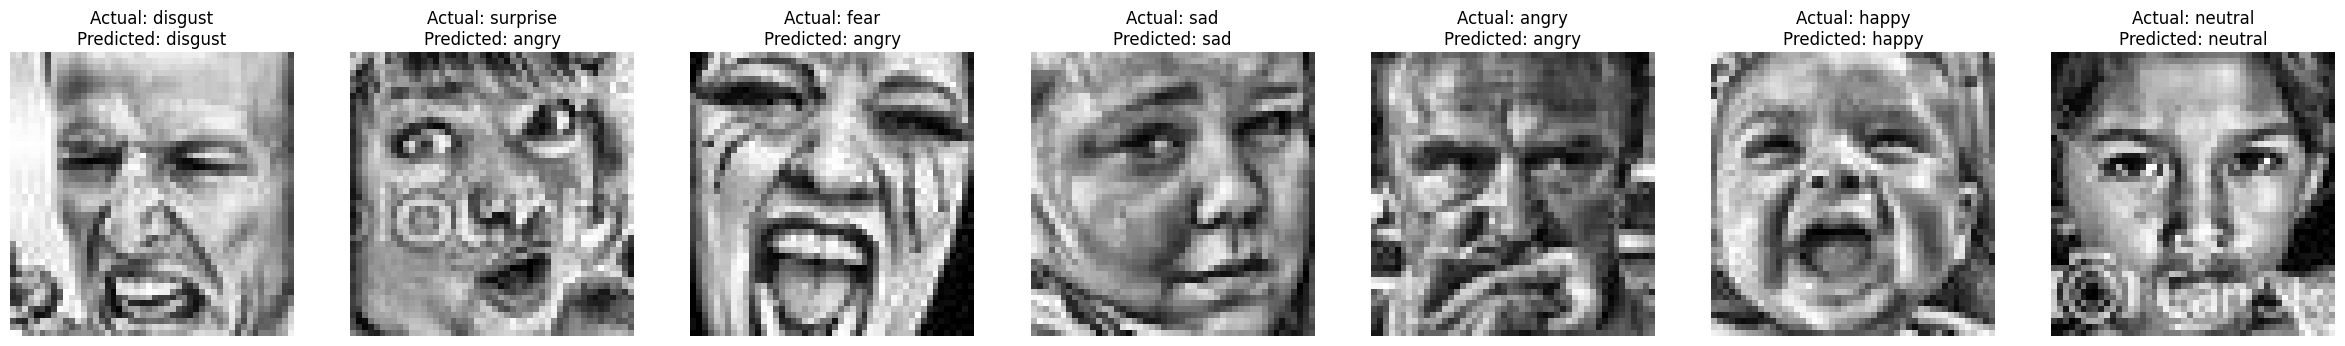

In [68]:
fig, axes = plt.subplots(1, len(selected_images), figsize=(30, 5))
for i, (img, actual, predicted) in enumerate(zip(selected_images, selected_labels, predicted_labels)):
    ax = axes[i]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Actual: {actual}\nPredicted: {predicted}")

plt.show()